### Load required packages

In [7]:
import os
import cv2
import torch
import argparse
import datetime
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from model import VisionTransformer

### Set hyperparameter

In [8]:
def hyperparameters():
    parser = argparse.ArgumentParser()
    
    # Test Arguments
    parser.add_argument("--batch_size", type=int, default=128)
    parser.add_argument("--num_workers", type=int, default=2)
    parser.add_argument("--device", type=str, default="mps", choices=["cpu", "cuda", "mps"])
    parser.add_argument("--output_path", type=str, default='./output')
    parser.add_argument("--timestamp", type=str, default="1900-01-01-00-00")
    parser.add_argument("--mode", type=str, default="cifar", choices=['cifar', 'single-cifar', 'custom'])
    parser.add_argument("--no_image", default=False, action='store_true')

    # Data Arguments
    parser.add_argument("--image_size", type=int, default=32)
    parser.add_argument("--n_channels", type=int, default=3)
    parser.add_argument("--patch_size", type=int, default=4)
    parser.add_argument("--n_classes", type=int, default=10)
    parser.add_argument("--data_path", type=str, default='./data')
    parser.add_argument("--num_test_images", type=int, default=None)
    parser.add_argument("--index", type=int, default=20)
    parser.add_argument("--image_path", type=str, default=None)

    # ViT Arguments
    parser.add_argument("--embed_dim", type=int, default=128)
    parser.add_argument("--n_layers", type=int, default=12)
    parser.add_argument("--n_attention_heads", type=int, default=4)
    parser.add_argument("--forward_mul", type=int, default=2)
    parser.add_argument("--dropout", type=int, default=0.1)
    parser.add_argument("--model_path", type=str, default='model/vit-layer12-32-cifar10/vit-layer12-32-cifar10-199.pt')

    args = parser.parse_args("") # https://stackoverflow.com/a/69925856
    return args

args = hyperparameters()

### Set CIFAR-10 classes

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Get image and label

In [10]:
transform = transforms.Compose([
        transforms.Resize([args.image_size, args.image_size]),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
testset = torchvision.datasets.CIFAR10(root=args.data_path, train=False, 
                                        download=True, transform=transform)

image, label = testset.__getitem__(args.index)
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

Files already downloaded and verified
Image shape: torch.Size([3, 32, 32])
Label: 7


### Show image and label

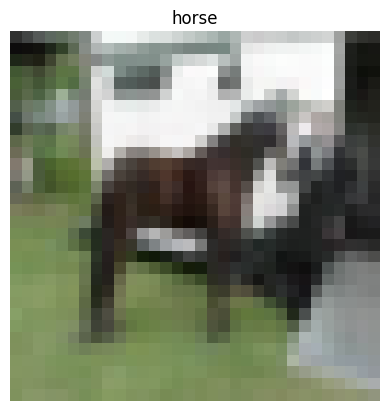

In [11]:
img = (image / 2 + 0.5).permute(1, 2, 0).numpy() # (c, h, w) -> (h, w, c)
plt.imshow(img)
plt.title(classes[label])
plt.axis('off')
plt.show()

### Prepare Vision Transformer model

In [12]:
model = VisionTransformer(args.n_channels, args.embed_dim, args.n_layers, 
                              args.n_attention_heads, args.forward_mul, args.image_size, 
                              args.patch_size, args.n_classes, args.dropout)
model.load_state_dict(torch.load(args.model_path, weights_only=True, map_location=args.device))
model.eval()
print(model)

VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ModuleList(
    (0-11): 12 x Encoder(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (queries): Linear(in_features=128, out_features=128, bias=True)
        (keys): Linear(in_features=128, out_features=128, bias=True)
        (values): Linear(in_features=128, out_features=128, bias=True)
        (out_projection): Linear(in_features=128, out_features=128, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=128, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=256, out_features=128, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((128,), eps=1e-05

### Pass image through ViT model

Here’s a line-by-line breakdown of this code snippet, which visualizes attention maps for a Vision Transformer (ViT) model:

1. **`logits, att_mat = model(x.unsqueeze(0))`**
   - The `model` processes the input `x` (an image or a tensor representing an image), which is first expanded to a batch of size 1 using `x.unsqueeze(0)`.
   - The output `logits` contains predictions, while `att_mat` contains the attention weights for each layer and head.

2. **`att_mat = torch.mean(att_mat, dim=1)`**
   - Averages attention weights across all heads in each layer. This step simplifies the attention representation to make it more interpretable, resulting in a shape `(num_layers, seq_length, seq_length)`.

3. **`residual_att = torch.eye(att_mat.size(1))`**
   - Creates an identity matrix the size of the sequence length (`seq_length x seq_length`). This matrix simulates residual connections, where each token attends to itself directly.

4. **`aug_att_mat = att_mat + residual_att`**
   - Adds the identity matrix to `att_mat`, introducing self-attention for each token.

5. **`aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)`**
   - Normalizes each attention matrix along the last dimension (summing to 1 across each row), ensuring the attention scores are correctly scaled for each token.

6. **`joint_attentions = torch.zeros(aug_att_mat.size())`**
   - Initializes `joint_attentions` to store cumulative attention weights across layers, which will later show how much each input token affects each output token across layers.

7. **`joint_attentions[0] = aug_att_mat[0]`**
   - Sets the first layer’s joint attention weights as the initial value in `joint_attentions`.

8. **`for n in range(1, aug_att_mat.size(0)):`**
   - Starts a loop to compute cumulative attention matrices for each layer, which compound layer-by-layer attention across the network.

9.  **`joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])`**
    - Recursively multiplies each layer’s augmented attention matrix with the joint attention matrix from the previous layer, effectively combining the attention maps from all layers up to layer `n`.

10. **`v = joint_attentions[-1]`**
    - Sets `v` to the final joint attention map. This contains the cumulative attention from the output token to the input tokens, allowing us to understand the overall attention.

11. **`grid_size = int(np.sqrt(aug_att_mat.size(-1)))`**
    - Computes the grid size based on the sequence length. For image patches, this is typically the square root of `seq_length` (assuming the tokens form a square grid).

12. **`mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()`**
    - Reshapes the attention map (excluding the `[CLS]` token at position 0) to a 2D grid. This map represents the influence of each patch on the final prediction.

13. **`mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]`**
    - Normalizes the mask to range from 0 to 1, resizes it to the original image’s size, and adds an extra channel dimension for compatibility with RGB images.

14. **`result = (mask * im).astype("uint8")`**
    - Multiplies the normalized mask with the original image to create a visualization where more attended regions appear brighter, and converts the result to an 8-bit image format for display.

In [13]:
logits, att_mat = model(image.unsqueeze(0))
print(f"Original attention weight shape: {att_mat.shape}")

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)
print(f"Average attention weight shape: {att_mat.shape}")

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
print(f"Augument attention weight shape: {aug_att_mat.shape}")

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0] # V
print(f"Joint attention weight shape: {joint_attentions.shape}")

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1]) # QK^T * V
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
print(f"Output weight shape: {v.shape}")
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
print(f"Grid size: {grid_size}")
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
print(f"Patch-wise attention shape: {mask.shape}")
mask = cv2.resize(mask / mask.max(), (img.shape[0], img.shape[1]))[..., np.newaxis]
print(f"Resized patch-wise attention shape: {mask.shape}")
result = (mask * img)
print(f"Original image shape: {img.shape}")
print(f"Attention weighted image shape: {result.shape}")

Original attention weight shape: torch.Size([12, 4, 65, 65])
Average attention weight shape: torch.Size([12, 65, 65])
Augument attention weight shape: torch.Size([12, 65, 65])
Joint attention weight shape: torch.Size([12, 65, 65])
Output weight shape: torch.Size([65, 65])
Grid size: 8
Patch-wise attention shape: (8, 8)
Resized patch-wise attention shape: (32, 32, 1)
Original image shape: (32, 32, 3)
Attention weighted image shape: (32, 32, 3)


Prediction Label and Attention Map!

0.99558 : horse
0.00177 : dog
0.00122 : truck
0.00057 : deer
0.00038 : car
0.00034 : plane
0.00004 : ship
0.00004 : cat
0.00004 : bird
0.00001 : frog


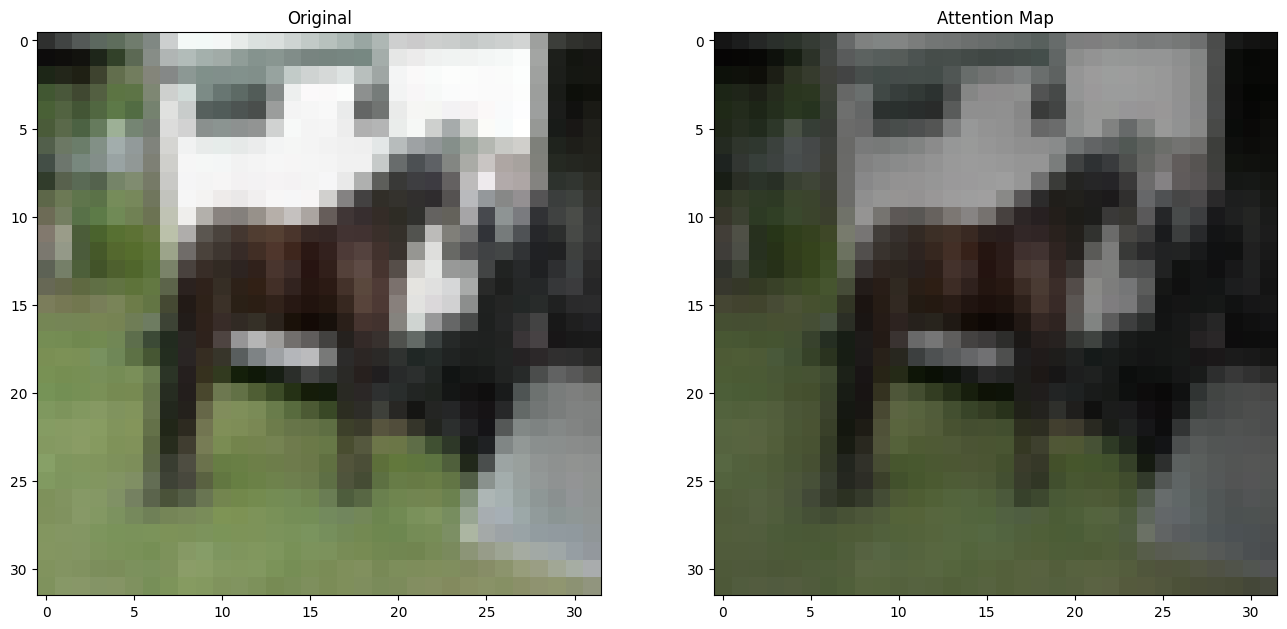

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top10 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top10[0, :10]:
    print(f'{probs[0, idx.item()]:.5f} : {classes[idx.item()]}\n', end='')

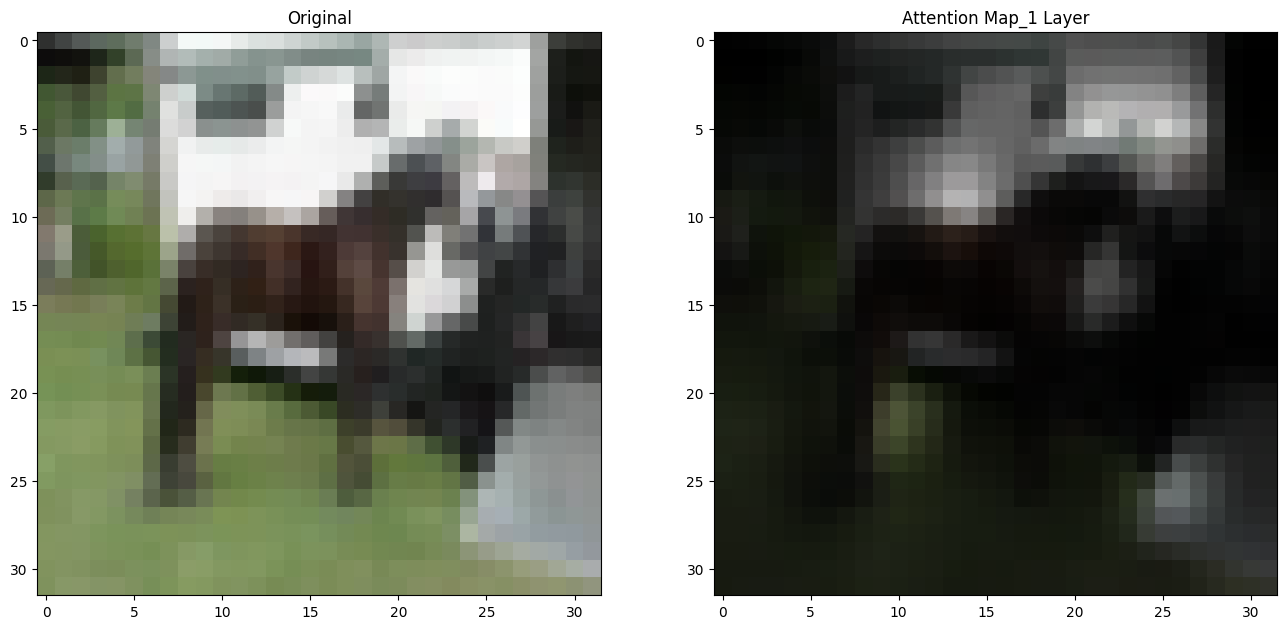

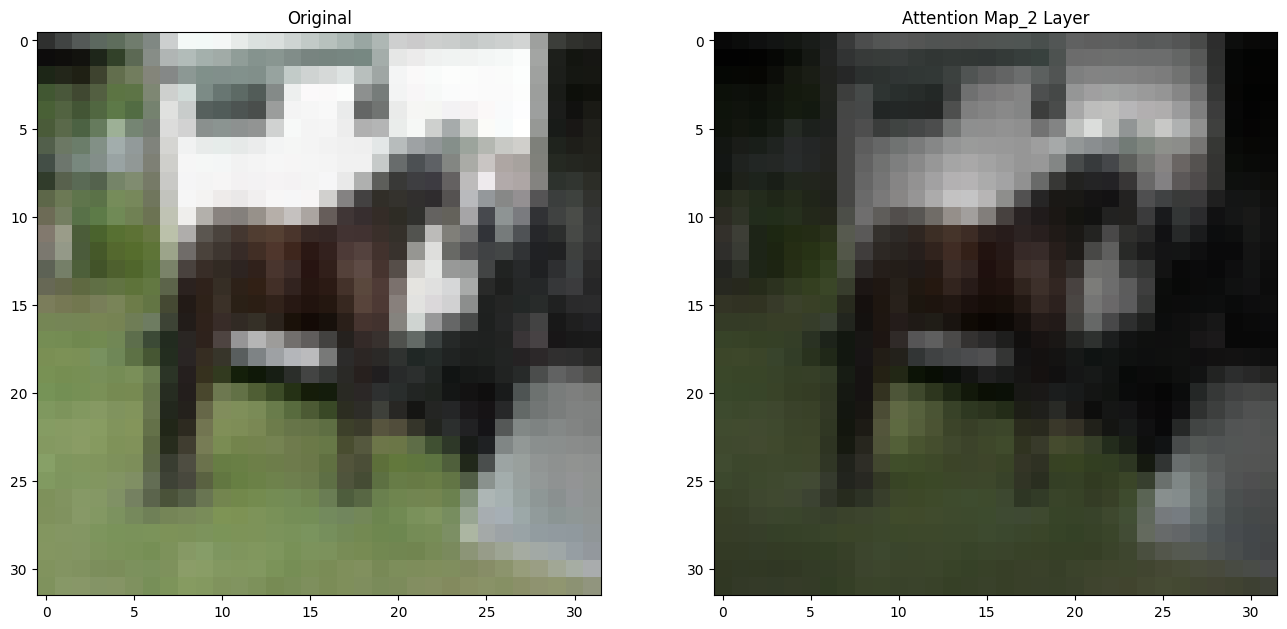

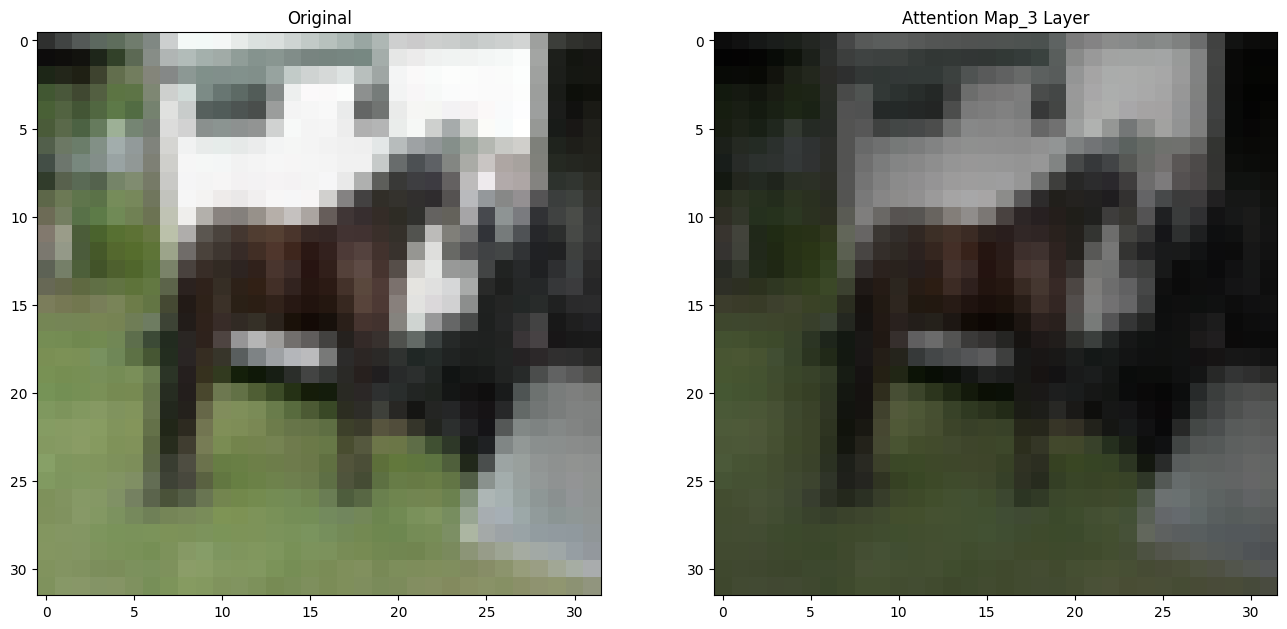

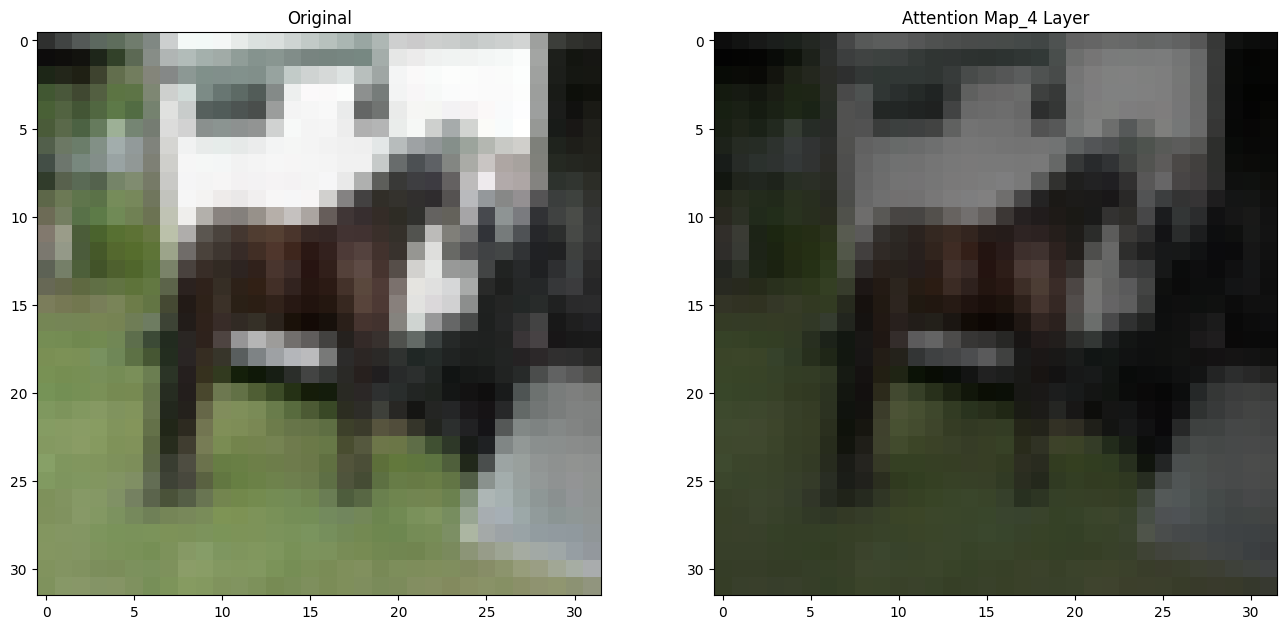

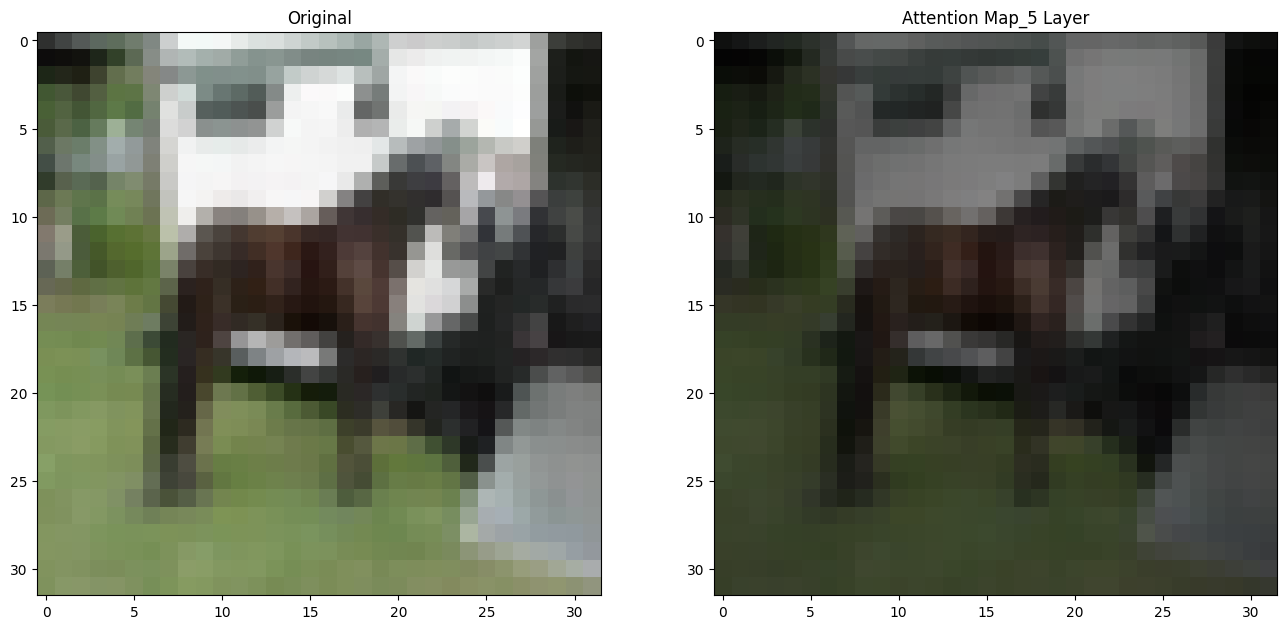

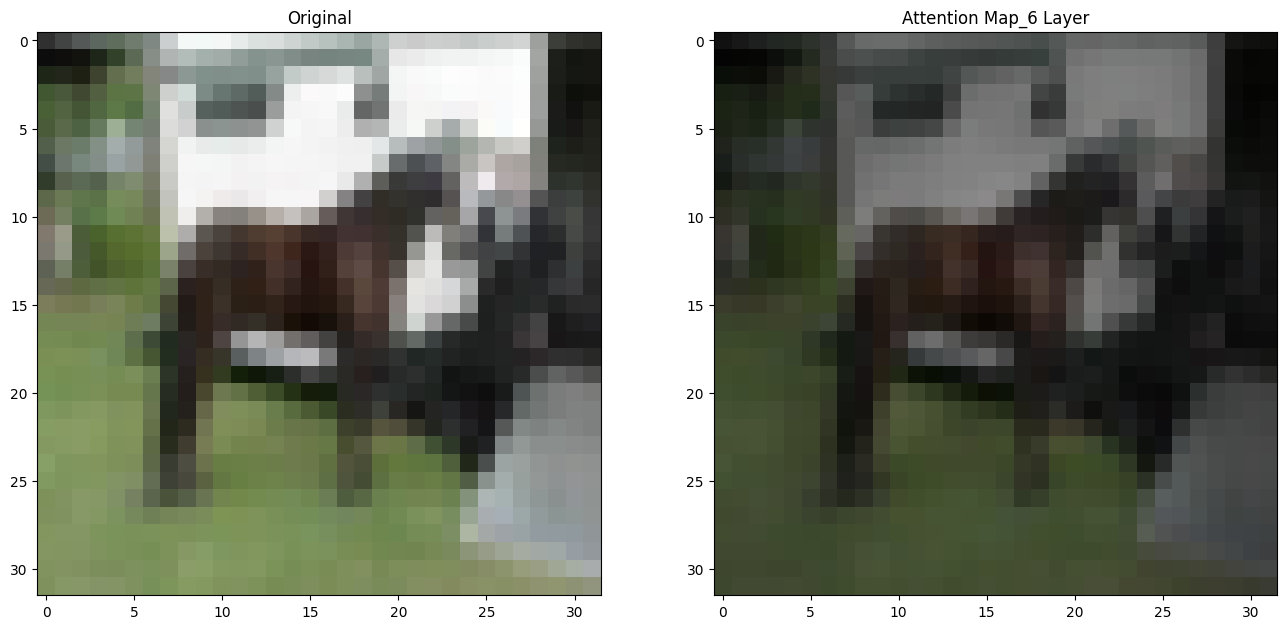

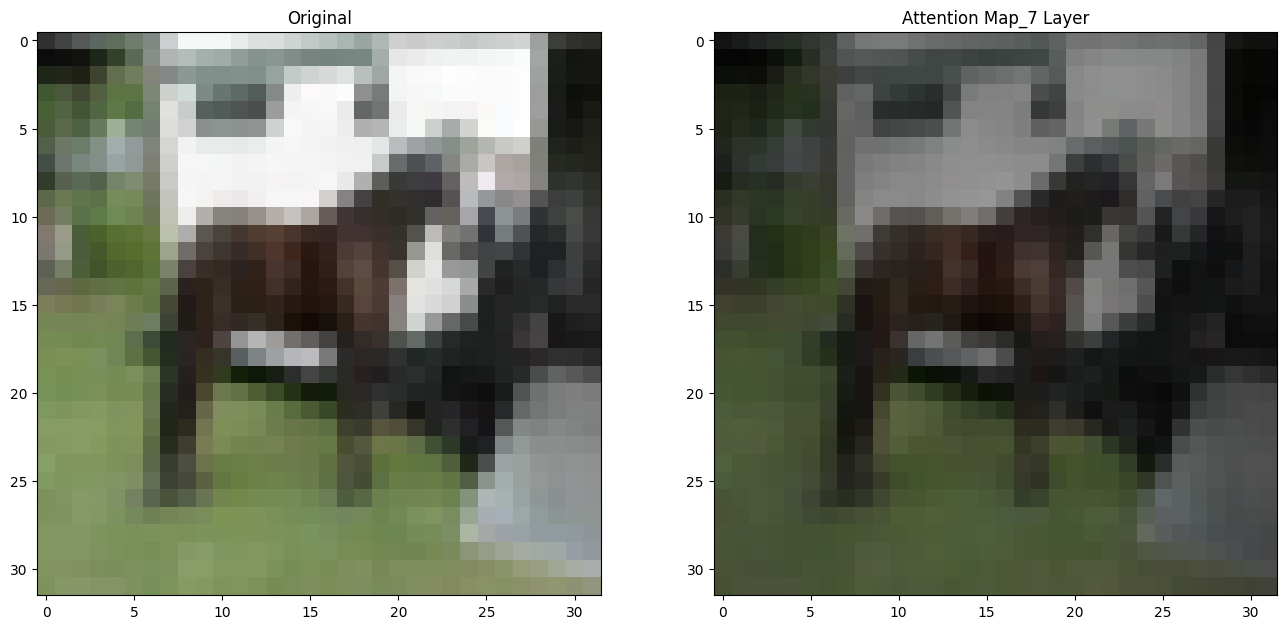

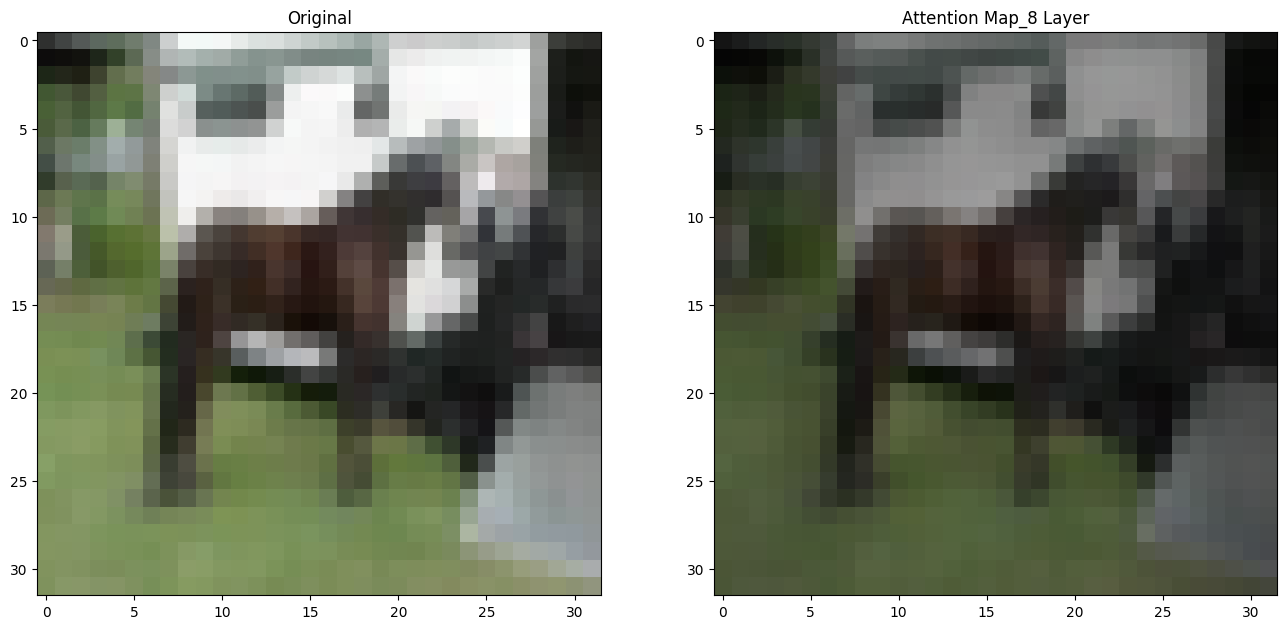

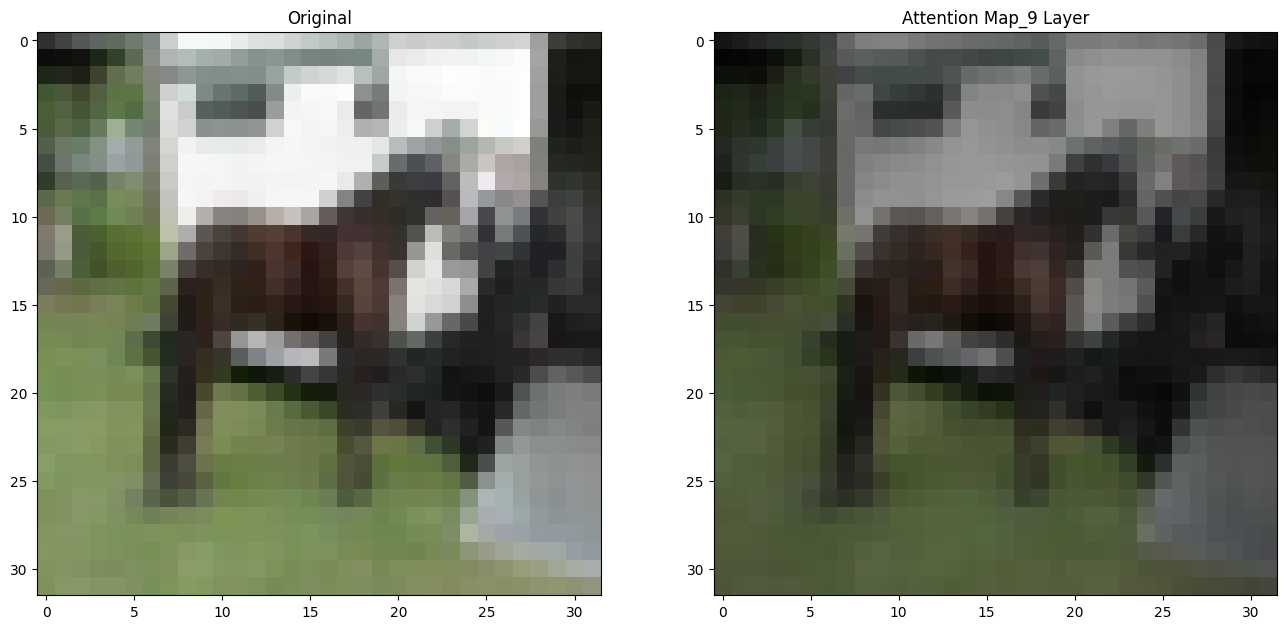

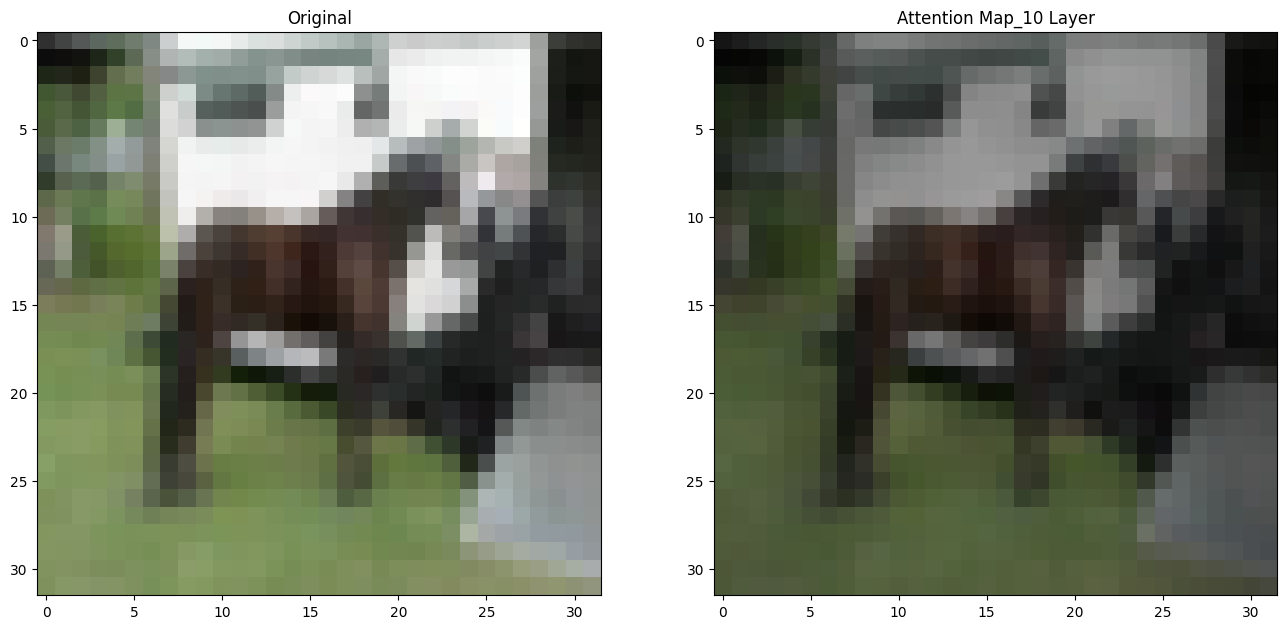

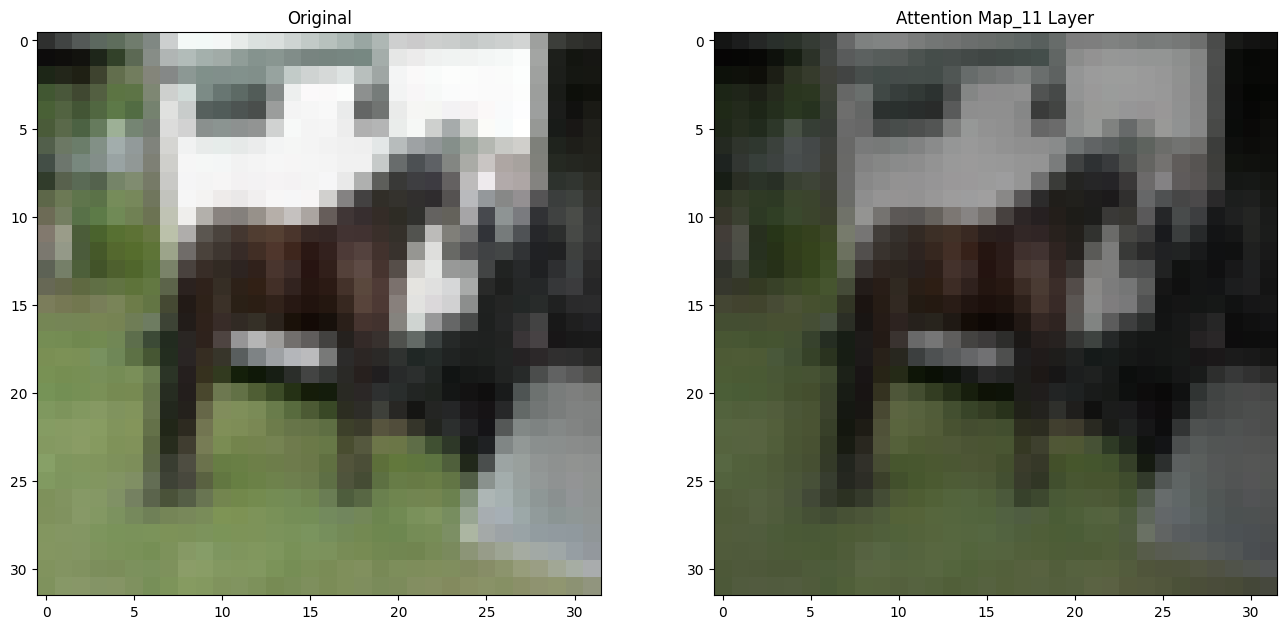

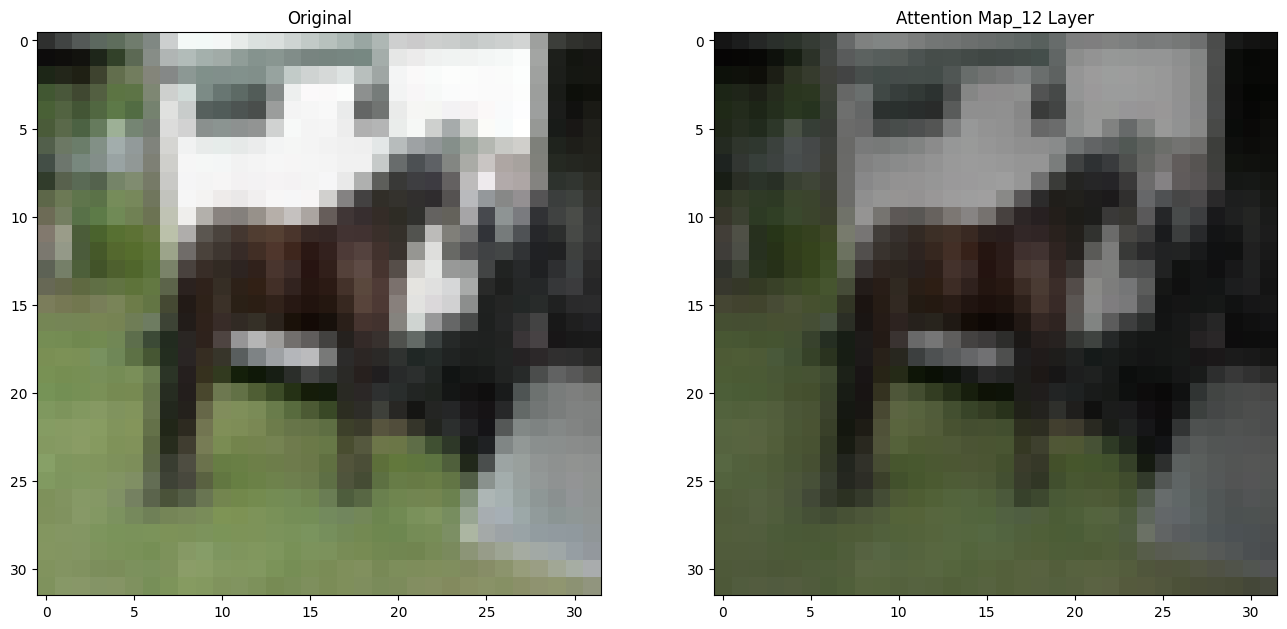

In [15]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), (img.shape[0], img.shape[1]))[..., np.newaxis]
    result = (mask * img)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(img)
    _ = ax2.imshow(result)